### Compare with VLMs

In [1]:
from copy import deepcopy
import pickle
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os
def align_smooth_scores(preds, time_points, smooth_win=10, complete_version=False):
    # cut predicted scores and time_points_german into 8 runs
    cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]

    time_points_ori = deepcopy(time_points)
    if not complete_version:
        time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
        time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
        time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
        time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

    # Find time points in the german version. (the frame rate was different from the original movie)
    time_points_german = time_points_ori / (25/(24000/1001))
    
    n_emos = preds.shape[1]
    preds_cut = np.zeros((0,n_emos))
    time_points_german_cut = np.zeros(0)
    for i in range(len(cut_index2)):
        preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
        time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

    # Get time of ratings in German version
    time_ratings = []
    seg_lens = [902,882,876,976,924,878,1084,676]
    for i in range(8):
        tmp = np.arange(0,seg_lens[i],2)
        if (i > 0) and (i < 7): # The first and the last runs only have one segment
            tmp = tmp + cut_index2[i*2-1][0]
            tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
        elif i == 7:
            tmp = tmp + cut_index2[i*2-1][0]
        time_ratings.extend(tmp)
        
    # Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
    preds_cut_resample = np.zeros((3599, n_emos))
    for i in range(3599):
        if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
            preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
        else:
            preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

    # Smooth the predicted scores over ts windows
    preds_smoothed = np.zeros(preds_cut_resample.shape)
    for i in range(preds_cut_resample.shape[0]):
        tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
        preds_smoothed[i,:] = np.mean(tmp, axis=0)
        # preds_smoothed[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    return preds_smoothed, time_ratings


def smooth_scores(preds_cut_resample, time_ratings, smooth_win=10):
    # Smooth the predicted scores over ts windows
    preds_smoothed = np.zeros(preds_cut_resample.shape)
    for i in range(preds_cut_resample.shape[0]):
        tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
        preds_smoothed[i,:] = np.mean(tmp, axis=0)
    return preds_smoothed

In [2]:
# VLM ratings
datadir = r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\VLM_model'
vlm=np.load(os.path.join(datadir,'vilamp_score.npy'))
vlm_time=np.array([i*2 for i in range(len(vlm))])
vlm_smoothed, time_ratings = align_smooth_scores(vlm, vlm_time, complete_version=True)

In [ ]:
# Human ratings
import h5py
path=r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\Lettieri-Forrest\forrest_gump_movie_italian\raw_ratings.mat'
human_movie=np.zeros([12,6,3599])
count = 0
with h5py.File(path,'r') as file:
    for item in file.items():
        # print(item[0])
        tmp = file[item[0]][:][[0,1,3,4,5,2],:] # reorder to [高兴、惊讶、悲伤、愤怒、厌恶、恐惧]
        human_movie[count]=tmp
        count += 1
human_movie_mean = np.mean(human_movie, axis=0)
human_movie_mean = human_movie_mean.transpose()

human_movie = human_movie.transpose([2,1,0])

In [4]:
file_path = r"\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample.pkl" 
with open(file_path, "rb") as f: 
    danmu_dict = pickle.load(f)
file='forrest_gump.csv'
time_ranges = danmu_dict[file+'_time_range']

time_points_llm_danmu = np.zeros(len(time_ranges))
for i in range(len(time_points_llm_danmu)):
    time_points_llm_danmu[i] = np.mean(time_ranges[i])

smooth_win=10
human_movie_aligned = np.zeros(human_movie.shape)
for j in range(12):
    human_movie_aligned[:,:,j] = smooth_scores(human_movie[:,:,j], time_ratings)
    
human_movie_mean_aligned = smooth_scores(human_movie_mean, time_ratings)

In [5]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo.keys())
preds = scores_allvideo['forrest_gump']
time_ranges = danmu_dict['forrest_gump.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over ts windows
smooth_win = 10
preds_smoothed = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
    preds_smoothed[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)

dict_keys(['error_count_list', 'forrest_gump'])


In [6]:
llm_danmu_aligned = preds_smoothed

In [8]:
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]

for i in range(6):
    print(emos[i], pearsonr(human_movie_mean_aligned[:,i], vlm_smoothed[:,i]),
          pearsonr(human_movie_mean_aligned[:,i], llm_danmu_aligned[:,i]))

Happiness PearsonRResult(statistic=0.3864454868145057, pvalue=1.593121752776236e-128) PearsonRResult(statistic=0.493309054078641, pvalue=4.161241296677213e-220)
Surprise PearsonRResult(statistic=0.1878219539723999, pvalue=6.2376163837449086e-30) PearsonRResult(statistic=0.35155677460310364, pvalue=3.422041121553503e-105)
Sadness PearsonRResult(statistic=0.4906483822953673, pvalue=2.0865339302561615e-217) PearsonRResult(statistic=0.6999156123077257, pvalue=0.0)
Anger PearsonRResult(statistic=0.2055011483940343, pvalue=1.276918361982699e-35) PearsonRResult(statistic=0.3469640259641978, pvalue=2.4769870478942623e-102)
Disgust PearsonRResult(statistic=0.0640657934229992, pvalue=0.00012004714629706921) PearsonRResult(statistic=0.30730948964193316, pvalue=1.4177861688612123e-79)
Fear PearsonRResult(statistic=0.559025504862309, pvalue=5.016353398689102e-295) PearsonRResult(statistic=0.5323648448325551, pvalue=1.2569558336262357e-262)


C:\Users\Windows\AppData\Local\Temp\ipykernel_27368\2523399962.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


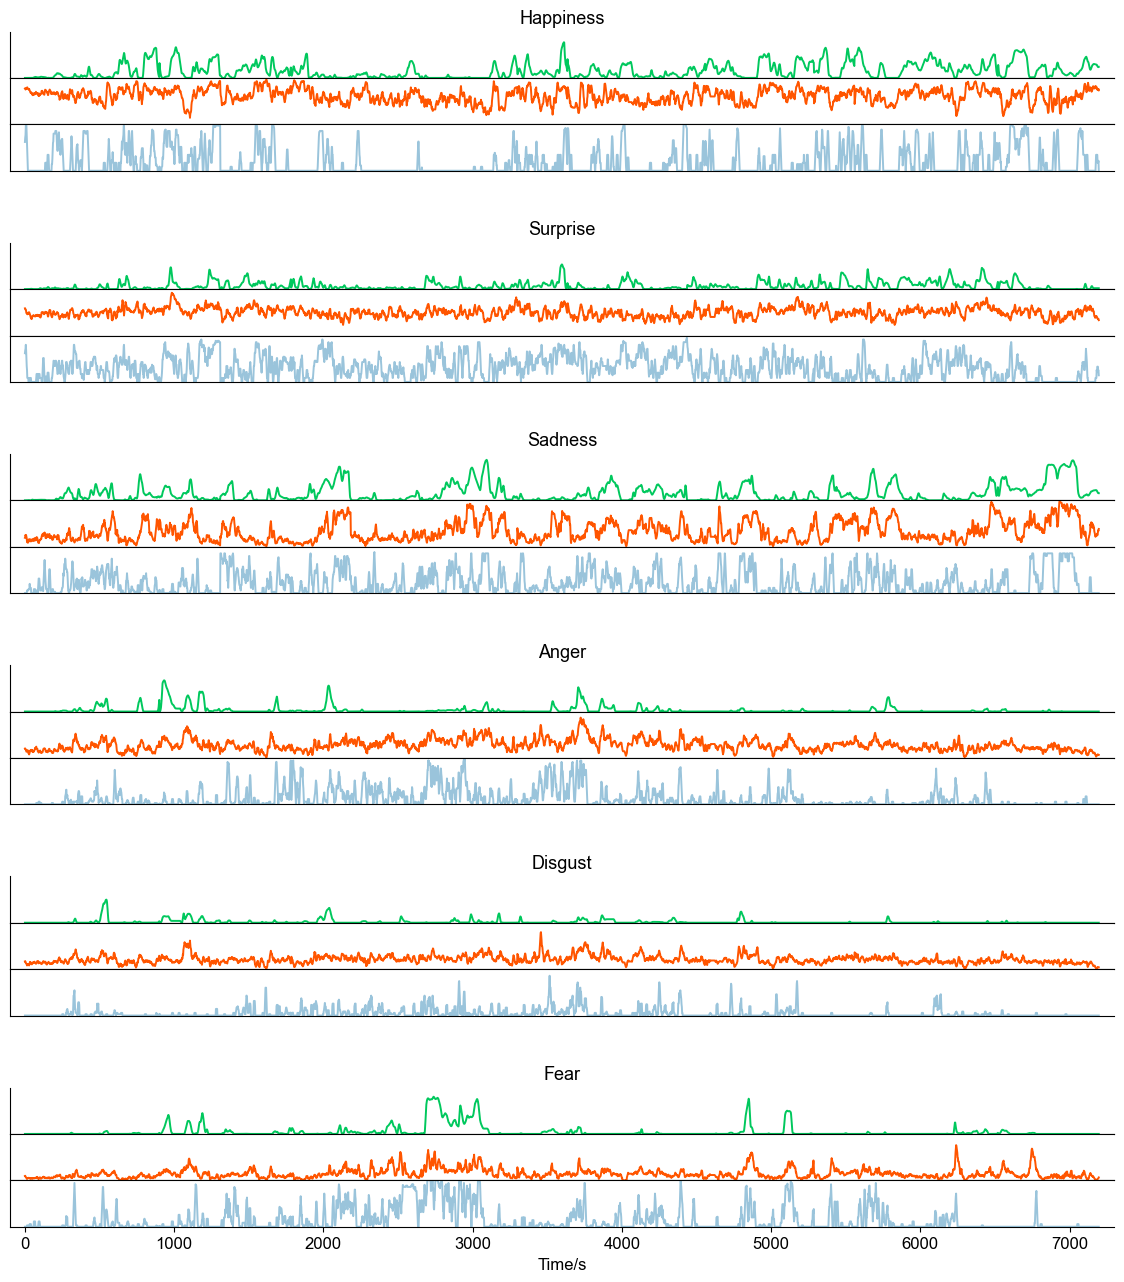

In [9]:
# Long movie
import h5py
from copy import deepcopy
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.patches as patches


# colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]

# colors1 = ['#d62728', '#ff7f0e', '#2ca02c']
# colors2 = ['#FF6666', '#F0AA34', '#66c2a5']
# colors3 = ['#a50f15', '#A36F14', '#1b7837']
# colors = ['#FFB6C1', [154/255,196/255,219/255], '#A6D854']
colors = ['#FF5500', [154/255,196/255,219/255], '#00C85D']
# danmu_human_smoothed_rescale = danmu_human_smoothed / 100. * 7.

vertical_gap_small = 0.001
vertical_gap_large = 0.06
height = 0.058*2/3
left1 = 0.05
right1 = 0.97
width = right1 - left1

fig = plt.figure(figsize=(12, 12))
plt.rcParams['font.family'] = 'Arial'
sel_inds = [0,1,2,3,4,5]
count = 0
for j in range(6):
    bottom1 = 1 - (j+1)*height*3 - j*vertical_gap_large
    bottom2 = bottom1 + height
    bottom3 = bottom1 + 2*height
    R = np.corrcoef(llm_danmu_aligned[:,sel_inds[count]], human_movie_mean_aligned[:,sel_inds[count]])[0,1]
    
    ax1 = fig.add_axes([left1, bottom3, width, height])
    ax1.plot(np.arange(llm_danmu_aligned.shape[0])*2, human_movie_mean_aligned[:llm_danmu_aligned.shape[0], sel_inds[count]]/100.*7., color=colors[2], linewidth=1.4)
    # ax1.plot(np.arange(llm_danmu_aligned.shape[0]//2)*2, llm_danmu_aligned[:llm_danmu_aligned.shape[0]//2, sel_inds[count]], color=colors[0], linewidth=1.4)
    ax1.set_ylim([0, 7])
    ax1.set_xlim([-100,llm_danmu_aligned.shape[0]*2+100])
    ax1.set_title(emos[sel_inds[count]], fontsize=13)
    # ax1.set_yticks([0,4], [0,4], fontsize=10)
    ax1.set_yticks([])
    ax1.set_xticks([])
    # ax1.set_ylabel('LLM ratings for Danmu', fontsize=10, rotation=0, labelpad=60)
    # ax1.yaxis.label.set_position((0, 0.3))
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    
    ax2 = fig.add_axes([left1, bottom2, width, height])
    ax2.plot(np.arange(llm_danmu_aligned.shape[0])*2, llm_danmu_aligned[:llm_danmu_aligned.shape[0], sel_inds[count]], color=colors[0], linewidth=1.4)
    ax2.set_ylim([0, 7])
    ax2.set_xlim([-100,llm_danmu_aligned.shape[0]*2+100])
    # ax2.set_title(emos[j], fontsize=15)
    # ax2.set_yticks([0,4], [0,4], fontsize=10)
    ax2.set_yticks([])
    ax2.set_xticks([])
    # ax2.set_ylabel('Human ratings for the movie', fontsize=10, rotation=0, labelpad=70)
    # ax2.yaxis.label.set_position((0, 0.3))
    ax2.spines['right'].set_visible(False)    
    
    ax3 = fig.add_axes([left1, bottom1, width, height])
    ax3.plot(np.arange(llm_danmu_aligned.shape[0])*2, vlm_smoothed[:llm_danmu_aligned.shape[0], sel_inds[count]], color=colors[1], linewidth=1.4)
    ax3.set_ylim([0, 7])
    ax3.set_xlim([-100,llm_danmu_aligned.shape[0]*2+100])
    # ax3.set_yticks([0,4], [0,4], fontsize=10)
    ax3.set_yticks([])
    ax3.set_xticks([])
    # ax3.set_ylabel('Human ratings for the movie', fontsize=10, rotation=0, labelpad=70)
    # ax3.yaxis.label.set_position((0, 0.3))
    
    ax3.spines['right'].set_visible(False)
    
    count += 1
    
ax3.set_xlabel('Time/s', fontsize=12)
ax3.set_xticks(np.arange(0,llm_danmu_aligned.shape[0]*2,1000), np.arange(0,llm_danmu_aligned.shape[0]*2,1000), fontsize=12)
# plt.legend(['Human ratings for the movie', 'LLM ratings for Danmu', 'VLM ratings for the movie'])
plt.tight_layout()
plt.savefig('figures/llm_vlm.svg', dpi=300, bbox_inches='tight')
# plt.savefig('figures/prompt_v4_gpt3_5_turbo_longMovie_lineplot_human_danmu_short.jpg', dpi=300, bbox_inches='tight')
plt.show()


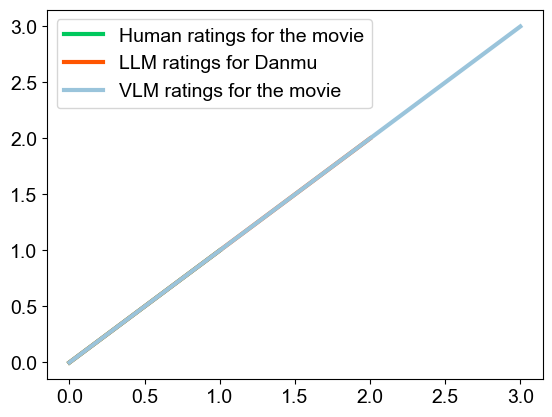

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

colors = ['#FF5500', [154/255,196/255,219/255], '#00C85D']
plt.plot([0,1], [0,1], color=colors[2], linewidth=3)
plt.plot([0,2], [0,2], color=colors[0], linewidth=3)
plt.plot([0,3], [0,3], color=colors[1], linewidth=3)

plt.legend(['Human ratings for the movie', 'LLM ratings for Danmu', 'VLM ratings for the movie'])
plt.savefig('figures/llm_vlm_legend.svg', dpi=300, bbox_inches='tight')

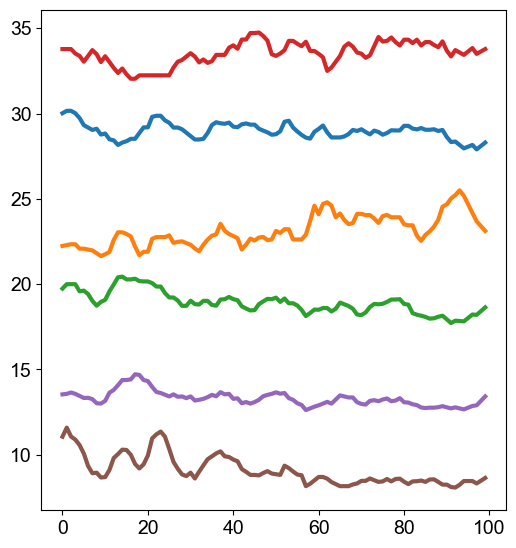

In [11]:
# Illustration
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
plt.figure(figsize=(6,6.5))
for i in range(6):
    plt.plot(30-4.6*i+preds_smoothed[1350:1450,i], color=colors[i], linewidth=3)
plt.savefig('figures/illus_figure2.svg', bbox_inches='tight')
plt.show()

### Emotion trajectories on THU

In [12]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import pickle
import matplotlib
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

In [13]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-ShortVideos\Emotion_scores\scores_allvideo_THU.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo['angry_08'].shape)

(53, 6)


In [14]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-ShortVideos\Processed_danmu\danmu_shortVideos_downsample.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.keys())

dict_keys(['angry_08.csv', 'angry_08.csv_time_range', 'angry_09.csv', 'angry_09.csv_time_range', 'angry_10.csv', 'angry_10.csv_time_range', 'disgust_01.csv', 'disgust_01.csv_time_range', 'disgust_08.csv', 'disgust_08.csv_time_range', 'disgust_10.csv', 'disgust_10.csv_time_range', 'elevation_02.csv', 'elevation_02.csv_time_range', 'elevation_08.csv', 'elevation_08.csv_time_range', 'elevation_09.csv', 'elevation_09.csv_time_range', 'fear_03.csv', 'fear_03.csv_time_range', 'fear_08.csv', 'fear_08.csv_time_range', 'fear_09.csv', 'fear_09.csv_time_range', 'humor_03.csv', 'humor_03.csv_time_range', 'humor_07.csv', 'humor_07.csv_time_range', 'humor_08.csv', 'humor_08.csv_time_range', 'neutral_04.csv', 'neutral_04.csv_time_range', 'neutral_05.csv', 'neutral_05.csv_time_range', 'neutral_07.csv', 'neutral_07.csv_time_range', 'sad_01.csv', 'sad_01.csv_time_range', 'sad_02.csv', 'sad_02.csv_time_range', 'sad_03.csv', 'sad_03.csv_time_range', 'sad_04.csv', 'sad_04.csv_time_range', 'sad_05.csv', 'sa

In [15]:
# Smooth the predicted scores over 10s windows
def smooth_scores(preds, time_ratings, smooth_win=10):
    preds_smoothed = np.zeros(preds.shape)
    for i in range(preds.shape[0]):
        tmp = preds[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
        preds_smoothed[i,:] = np.mean(tmp, axis=0)
    return preds_smoothed

In [16]:
matplotlib.rcParams['font.family'] = 'Arial'
names_new = ['angry_08', 'angry_09', 'angry_10', 'disgust_01', 'disgust_08', 'disgust_10', 'fear_03', 'fear_08', 'fear_09', 'humor_03', 'humor_07', 'humor_08', 'sad_02', 'sad_05', 'sad_06', 'surprise_03', 'surprise_07', 'surprise_10']

emo_categ = ['Angry', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
scores_concat = np.zeros((0,6))
emo_labels = np.zeros(0)
vid_labels = np.zeros(0)
for count in range(len(names_new)):
    time_ranges = data['%s.csv_time_range' % names_new[count]]
    time_ratings = np.zeros(len(time_ranges))
    for i in range(len(time_ratings)):
        time_ratings[i] = np.mean(time_ranges[i])
    scores_now = scores_allvideo[names_new[count]]
    preds_smoothed = smooth_scores(scores_now, time_ratings, smooth_win=20)
    scores_concat = np.concatenate((scores_concat, preds_smoothed))
    label_now = np.ones(len(time_ratings))*count//3
    emo_labels = np.concatenate((emo_labels, label_now.astype(int)))
    vid_labels = np.concatenate((vid_labels, np.ones(len(time_ratings))*count))
emo_labels = emo_labels.astype(int)
vid_labels = vid_labels.astype(int)
print(scores_concat.shape)

(1149, 6)


In [17]:
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(scores_concat)

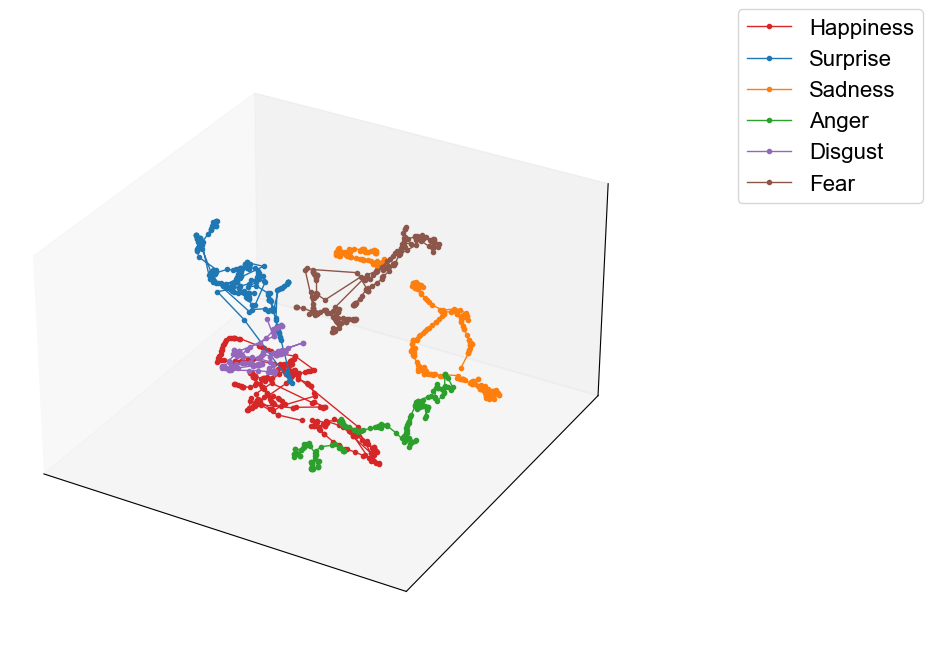

In [19]:
plt.rcParams['font.size']=16
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 0.6])

colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

count = 0
for label in [9,10,11,15,16,17,12,13,14,0,1,2,3,4,5,6,7,8]:
    category_data = X_tsne[vid_labels == label]
    emo_label = int(count // 3)
    
    vid_mod = np.mod(label, 3)
    
    if vid_mod == 0:
        ax.plot(category_data[:, 0], category_data[:, 1], category_data[:, 2], 
                color=colors[emo_label], label=emos[emo_label], marker='.', linewidth=1.0, markersize=6)
    else:
        ax.plot(category_data[:, 0], category_data[:, 1], category_data[:, 2], 
                color=colors[emo_label], marker='.', linewidth=1.0, markersize=6)
    count += 1

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_facecolor('white')
ax.grid(False)

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05))

plt.savefig('figures/short_videos_tsne.svg')
plt.show()

### VAD

In [20]:
import matplotlib.pyplot as plt
import numpy as np

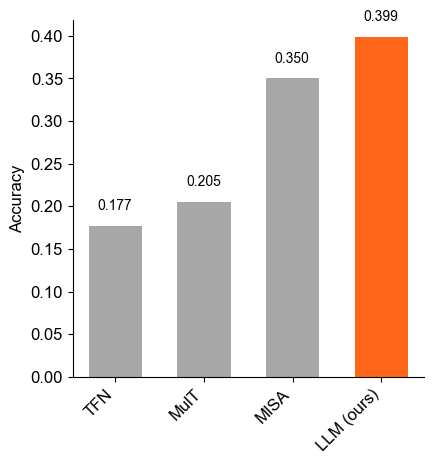

In [21]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

models = ['TFN', 'MulT', 'MISA', 'LLM (ours)']
acc = [0.177, 0.205, 0.350, 0.399]

data = acc
x = np.arange(len(models))

colors = ['#9e9e9e', '#9e9e9e', '#9e9e9e', '#FF5500']

# ----------------
# plot
# ----------------
fig, ax = plt.subplots(figsize=(4.5, 4.8))

bars = ax.bar(x, data, color=colors, width=0.6, alpha=0.9)

for xi, v in zip(x, data):
    ax.text(xi-0.005, v + 0.015, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')

ax.set_ylabel("Accuracy", fontsize=12)
x_start = -0.4
x_end   = len(models) - 0.7 


# 取消外框
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/ACC_only_comparison.svg', bbox_inches='tight', dpi=300)
plt.show()


### Performance scaling with model sizes

In [22]:
import h5py
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Online_human_ratings_danmu\ratings6_sorted_final_12sub.pkl', 'rb') as f:
    human_danmu = pickle.load(f)
    
data_keys = np.arange(0,5756,5)
# data_keys = list(human_danmu.keys())
# time_points_human_danmu = np.zeros(len(data_keys))
human_danmu_mean = np.zeros((len(data_keys), 6))
for i in range(len(data_keys)):
    # time_points_human_danmu[i] = data_keys[i]
    human_danmu_mean[i,:] = np.mean(np.array(human_danmu[data_keys[i]]), axis=1)
    
human_danmu_3 = np.zeros((1152, 6, 12))
for i in range(len(data_keys)):
    # print(data[data_keys[i]])
    for j in range(6):
        for k in range(12):
            human_danmu_3[i,j,k] = human_danmu[data_keys[i]][j][k]
            
path=r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\Lettieri-Forrest\forrest_gump_movie_italian\raw_ratings.mat'
human_movie=np.zeros([12,6,3599])
count = 0
with h5py.File(path,'r') as file:
    for item in file.items():
        # print(item[0])
        tmp = file[item[0]][:][[0,1,3,4,5,2],:] # reorder to [高兴、惊讶、悲伤、愤怒、厌恶、恐惧]
        human_movie[count]=tmp
        count += 1
human_movie_mean = np.mean(human_movie, axis=0)
human_movie_mean = human_movie_mean.transpose()

human_movie = human_movie.transpose([2,1,0])

In [28]:
datadir = r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\Other_NLP_models'
np_list=os.listdir(datadir)
names = ['chinese-roberta-wwm-ext', 'llama', 'Randeng-T5-Char-700M-Chinese', 'bert_chinese', 'bert_emotion_Classifier', 'gpt2-chinese-cluecorpussmall', 'Deberta-Chinese-Large', 'deepseek-r1']
np_list=['forrest_gump_'+names[i]+'.npy' for i in range(len(names))]
print(np_list)

model_list=['Roberta-102M','LLaMA7B-Instruct','T5-700M','BERT-110M','BERT-emotion-110M','GPT2-108M','DeBERT-320M', 'DeepSeek-R1']
parameter_num=[102000000,8000000000,700000000,110000000,110000000,108000000,320000000,671000000000]

['forrest_gump_chinese-roberta-wwm-ext.npy', 'forrest_gump_llama.npy', 'forrest_gump_Randeng-T5-Char-700M-Chinese.npy', 'forrest_gump_bert_chinese.npy', 'forrest_gump_bert_emotion_Classifier.npy', 'forrest_gump_gpt2-chinese-cluecorpussmall.npy', 'forrest_gump_Deberta-Chinese-Large.npy', 'forrest_gump_deepseek-r1.npy']


In [13]:
score_list=[]
count = 0
for score_file in np_list:
    llm_danmu=np.load(os.path.join(datadir, score_file))
    file_path = r"Y:\xinke\Danmu\DyEmo-film\Processed_danmu\movie_batch1\danmu_forrest_gump_downsample.pkl" 
    with open(file_path, "rb") as f: 
        danmu_dict = pickle.load(f)
    file='forrest_gump.csv'
    time_ranges = danmu_dict[file+'_time_range']

    time_points_llm_danmu = np.zeros(len(time_ranges))
    for i in range(len(time_points_llm_danmu)):
        time_points_llm_danmu[i] = np.mean(time_ranges[i])

    time_points_human_danmu = time_points_llm_danmu[np.arange(0,5756,5)]
    human_danmu_3_aligned = np.zeros((3599,6,12))
    for j in range(12):
        human_danmu_3_aligned[:,:,j], _ = align_smooth_scores(human_danmu_3[:,:,j], time_points_human_danmu)
    human_danmu_mean_aligned, _ = align_smooth_scores(human_danmu_mean, time_points_human_danmu)

    llm_danmu_aligned, time_ratings = align_smooth_scores(llm_danmu, time_points_llm_danmu)

    smooth_win=10
    human_movie_aligned = np.zeros(human_movie.shape)
    for j in range(12):
        human_movie_aligned[:,:,j] = smooth_scores(human_movie[:,:,j], time_ratings)
        
    human_movie_mean_aligned = smooth_scores(human_movie_mean, time_ratings)
    llm_r=np.zeros(6)
    for i in range(6):
        llm_r[i]=pearsonr(llm_danmu_aligned[:,i], human_movie_mean_aligned[:,i])[0]
        print(pearsonr(llm_danmu_aligned[:,i], human_movie_mean_aligned[:,i]))
    score_list.append(llm_r)
    count += 1

PearsonRResult(statistic=0.18115341452453704, pvalue=6.310696099232548e-28)
PearsonRResult(statistic=0.08492437139179616, pvalue=3.3572084912451935e-07)
PearsonRResult(statistic=0.3441398200898316, pvalue=1.3449540091415975e-100)
PearsonRResult(statistic=0.1124710263952671, pvalue=1.3197253073154497e-11)
PearsonRResult(statistic=0.03219965996467487, pvalue=0.053416178014492305)
PearsonRResult(statistic=0.06139809010386588, pvalue=0.00022818999119331466)
PearsonRResult(statistic=0.4606431541252516, pvalue=1.4862063251230852e-188)
PearsonRResult(statistic=0.2343701696065953, pvalue=4.211762914312259e-46)
PearsonRResult(statistic=0.6834404489384989, pvalue=0.0)
PearsonRResult(statistic=0.31074683995214686, pvalue=2.052193462698981e-81)
PearsonRResult(statistic=0.274767087684408, pvalue=2.3424583848581508e-63)
PearsonRResult(statistic=0.5266663908803518, pvalue=4.512327150852156e-256)
PearsonRResult(statistic=0.23272367908827946, pvalue=1.8316873134185896e-45)
PearsonRResult(statistic=0.19

In [14]:
r_gpt3_5_turbo = [0.482, 0.339, 0.690, 0.340, 0.298, 0.526]
r_gpt4o = [0.437, 0.318, 0.695, 0.351, 0.347, 0.494]
r_kimi = [0.467, 0.246, 0.711, 0.352, 0.318, 0.505]
score_list.append(r_gpt3_5_turbo)
score_list.append(r_gpt4o)
score_list.append(r_kimi)

In [15]:
score_list = score_list[:11]

In [16]:
for i in range(8,11):
    score_list[i] = np.array(score_list[i])

In [29]:
model_list.extend(['GPT-3.5', 'GPT-4o', 'Moonshot-v1'])
parameter_num.extend([2*10**10, 2*10**11, 3.2*10**10])
print(model_list, parameter_num)

['Roberta-102M', 'LLaMA7B-Instruct', 'T5-700M', 'BERT-110M', 'BERT-emotion-110M', 'GPT2-108M', 'DeBERT-320M', 'DeepSeek-R1', 'GPT-3.5', 'GPT-4o', 'Moonshot-v1'] [102000000, 8000000000, 700000000, 110000000, 110000000, 108000000, 320000000, 671000000000, 20000000000, 200000000000, 32000000000.0]


In [32]:
parameter_num = np.array(parameter_num)

In [25]:
rs_dict = {}
for i in range(11):
    rs_dict[model_list[i]] = score_list[i]
    
import pickle
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Emotion_scores\Other_NLP_models\rs_with_human.pkl', 'wb') as f:
    pickle.dump(rs_dict, f)

In [24]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\Other_NLP_models\rs_with_human.pkl', 'rb') as f:
    rs_with_human = pickle.load(f)
print(rs_with_human)

{'Roberta-102M': array([0.18115341, 0.08492437, 0.34413982, 0.11247103, 0.03219966,
       0.06139809]), 'LLaMA7B-Instruct': array([0.46064315, 0.23437017, 0.68344045, 0.31074684, 0.27476709,
       0.52666639]), 'T5-700M': array([0.23272368, 0.19176116, 0.46900219, 0.17016066, 0.12799891,
       0.30221022]), 'BERT-110M': array([ 0.1537292 ,  0.05211986, -0.07709038, -0.03026533, -0.01297977,
        0.10413471]), 'BERT-emotion-110M': array([ 0.106323  , -0.02221277,  0.23197328,  0.0730099 ,  0.16628347,
       -0.01400154]), 'GPT2-108M': array([0.19201372, 0.06168973, 0.38250561, 0.00755536, 0.08173817,
       0.28887841]), 'DeBERT-320M': array([-0.06136931,  0.12067487,  0.42094541, -0.02007027,  0.13384259,
        0.2399907 ]), 'DeepSeek-R1': array([0.4475626 , 0.36537493, 0.69474398, 0.31629526, 0.26595161,
       0.47871888]), 'GPT-3.5': array([0.482, 0.339, 0.69 , 0.34 , 0.298, 0.526]), 'GPT-4o': array([0.437, 0.318, 0.695, 0.351, 0.347, 0.494]), 'Moonshot-v1': array([0.467, 0

In [30]:
score_list = []
for name in model_list:
    score_list.append(rs_with_human[name])
score_list = np.array(score_list)

C:\Users\Windows\AppData\Local\Temp\ipykernel_27368\1577518971.py:21: RuntimeWarning: overflow encountered in exp
  return a - b * np.exp(-c * x)
C:\Users\Windows\AppData\Local\Temp\ipykernel_27368\1577518971.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
C:\Users\Windows\AppData\Local\Temp\ipykernel_27368\1577518971.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


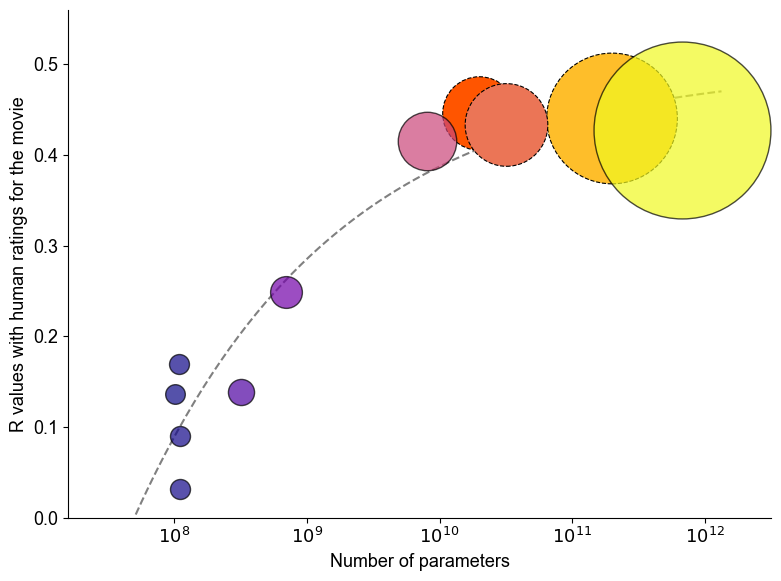

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 13

y_mean = np.mean(score_list, axis=-1)
y_std = np.std(score_list, axis=1) / np.sqrt(6)
x_values = np.log10(parameter_num)

sorted_indices = np.argsort(y_mean)[::-1]  # 降序索引
sorted_models = [model_list[i] for i in sorted_indices]
sorted_y_mean = y_mean[sorted_indices]
sorted_y_std = y_std[sorted_indices]
sorted_x = x_values[sorted_indices]
sorted_params = parameter_num[sorted_indices]

def saturating_func(x, a, b, c):
    return a - b * np.exp(-c * x)

popt, pcov = curve_fit(saturating_func, sorted_x, sorted_y_mean, p0=[0.5, 1.0, 2.0])
x_fit = np.linspace(np.min(sorted_x)-0.3, np.max(sorted_x)+0.3, 200)
y_fit = saturating_func(x_fit, *popt)

base_color = 'plasma'
color_gpt35 = '#FF5500'

norm = plt.Normalize(vmin=np.min(sorted_x), vmax=np.max(sorted_x))
sm = plt.cm.ScalarMappable(cmap=base_color, norm=norm)
sm.set_array([])  

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(11):
    if sorted_models[i] in ['GPT-3.5', 'GPT-4o', 'Moonshot-v1']:
        if sorted_models[i] == 'GPT-3.5':
            scatter = ax.scatter(
                x=sorted_x[i],  # 用排序后的x坐标
                y=sorted_y_mean[i],
                c=color_gpt35,  # 根据y_mean值映射颜色
                s=200 * np.sqrt(sorted_params[i]) / np.sqrt(np.min(sorted_params)),
                edgecolors='k',  # 改为灰色边框
                linewidths=0.8,
                linestyle='--',
                alpha=1.0,         # 设置透明度
                zorder=3,         # 确保点在误差线上方
                label=sorted_models[i]
            )
        else:
            scatter = ax.scatter(
                x=sorted_x[i],  # 用排序后的x坐标
                y=sorted_y_mean[i],
                c=sm.to_rgba(sorted_x[i]),  # 根据y_mean值映射颜色
                s=200 * np.sqrt(sorted_params[i]) / np.sqrt(np.min(sorted_params)),
                edgecolors='k',  # 改为灰色边框
                linewidths=0.8,
                linestyle='--',
                alpha=1.0,         # 设置透明度
                zorder=3,         # 确保点在误差线上方
                label=sorted_models[i]
            )
    else:
        scatter = ax.scatter(
            x=sorted_x[i],  # 用排序后的x坐标
            y=sorted_y_mean[i],
            c=sm.to_rgba(sorted_x[i]),  # 根据y_mean值映射颜色
            s=200 * np.sqrt(sorted_params[i]) / np.sqrt(np.min(sorted_params)),
            edgecolors='k',  # 黑色边框
            linewidths=1.0,
            zorder=3,         # 确保点在误差线上方
            alpha=0.7,
            label=sorted_models[i]
        )

ax.plot(x_fit, y_fit, '--', color='gray', linewidth=1.5, label='Saturating fit')

ax.set_xlim([7.2, 12.5])
ax.set_ylim([0, 0.56])
ax.set_xticks(np.log10([1e8, 1e9, 1e10, 1e11, 1e12]))
ax.set_xticklabels([r'$10^8$', r'$10^9$', r'$10^{10}$', r'$10^{11}$', r'$10^{12}$'], fontsize=13)
ax.set_xlabel("Number of parameters", fontsize=13)
ax.set_ylabel('R values with human ratings for the movie', fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.tight_layout()
plt.savefig('figures/nlp_sizes3_noalpha.svg', dpi=300, bbox_inches='tight')
plt.show()


In [34]:
# Get colors
norm = plt.Normalize(vmin=np.min(sorted_x), vmax=np.max(sorted_x)+0.3)
sm = plt.cm.ScalarMappable(cmap=base_color, norm=norm)
sm.set_array([])  # 为了在图例中显示颜色条

colors_4llms = []
colors_4llms.append('#FF5500')
for i in range(11):
    if sorted_models[i] in ['GPT-4o', 'Moonshot-v1', 'DeepSeek-R1']:
        colors_4llms.append(sm.to_rgba(sorted_x[i]))

### Radar plot on THU

In [35]:
import scipy.io as sio
import os
from scipy import stats

video_order = sio.loadmat(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-ShortVideos\Human_ratings\ratings_dimensions_nodanmu.mat')['names_new']
scores_subs = sio.loadmat(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-ShortVideos\Human_ratings\ratings_dimensions_nodanmu.mat')['scores_all']

sel_dims = [6,4,3,0,1,2]
scores_use = np.zeros((23,18,6))
scores_use[:,:3,:] = scores_subs[:,12:15,sel_dims]
scores_use[:,3:6,:] = scores_subs[:,-3:,sel_dims]
scores_use[:,6:9,:] = scores_subs[:,-6:-3,sel_dims]
scores_use[:,9:12,:] = scores_subs[:,:3,sel_dims]
scores_use[:,12:15,:] = scores_subs[:,3:6,sel_dims]
scores_use[:,15:18,:] = scores_subs[:,9:12,sel_dims]
scores_human = np.mean(scores_use, axis=0)
print(scores_human.shape)
scores_human_mean = np.zeros((6,6))
for i in range(6):
    scores_human_mean[i,:] = np.mean(scores_human[3*i:3*(i+1),:], axis=0)

(18, 6)


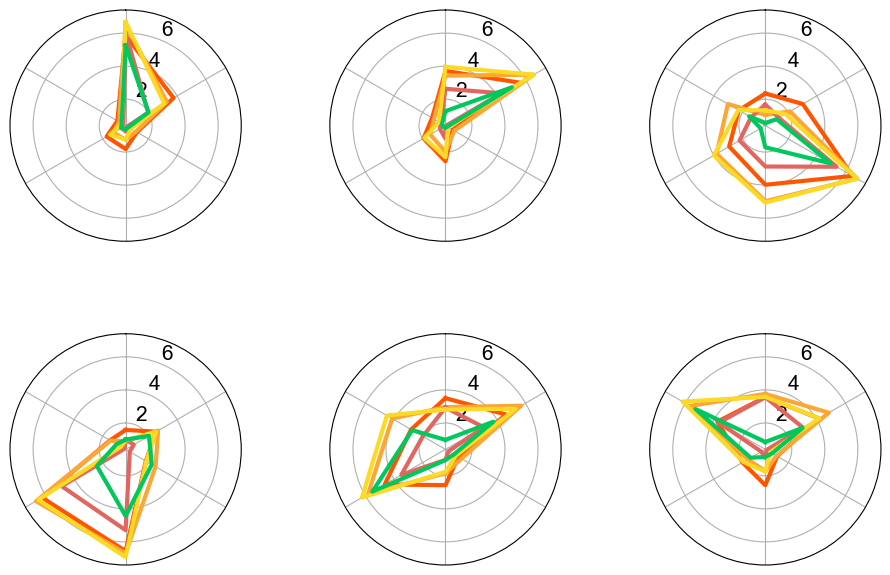

In [37]:
import matplotlib
import pickle
import matplotlib.pyplot as plt

resultdir = r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-ShortVideos\Emotion_scores'
with open(os.path.join(resultdir, 'scores_allvideo_deepseek.pkl'), 'rb') as f:
    scores_allvideo = pickle.load(f)
# print(scores_allvideo.keys())
matplotlib.rcParams['font.family'] = 'Arial'
names_new = ['angry_08', 'angry_09', 'angry_10', 'disgust_01', 'disgust_08', 'disgust_10', 'fear_03', 'fear_08', 'fear_09', 'humor_03', 'humor_07', 'humor_08', 'sad_02', 'sad_05', 'sad_06', 'surprise_03', 'surprise_07', 'surprise_10']
ds_data = np.zeros((6,6))
# scores_std = np.zeros((6,6))
count0 = 0
for count in range(0,len(names_new),3):
    scores_tmp = np.zeros((0,6))
    for i in range(3):
        scores_tmp = np.concatenate((scores_tmp, scores_allvideo[names_new[count+i]]),0)
    ds_data[count0] = np.mean(scores_tmp, axis=0)
    # scores_std[count0] = np.std(scores_tmp, axis=0)
    count0 += 1
ds_data = ds_data[[3,5,4,0,1,2]]


with open(os.path.join(resultdir, 'scores_allvideo_kimi.pkl'), 'rb') as f:
    scores_allvideo = pickle.load(f)

matplotlib.rcParams['font.family'] = 'Arial'
names_new = ['angry_08', 'angry_09', 'angry_10', 'disgust_01', 'disgust_08', 'disgust_10', 'fear_03', 'fear_08', 'fear_09', 'humor_03', 'humor_07', 'humor_08', 'sad_02', 'sad_05', 'sad_06', 'surprise_03', 'surprise_07', 'surprise_10']
kimi_data = np.zeros((6,6))
# scores_std = np.zeros((6,6))
count0 = 0
for count in range(0,len(names_new),3):
    scores_tmp = np.zeros((0,6))
    for i in range(3):
        scores_tmp = np.concatenate((scores_tmp, scores_allvideo[names_new[count+i]]),0)
    kimi_data[count0] = np.mean(scores_tmp, axis=0)
    # scores_std[count0] = np.std(scores_tmp, axis=0)
    count0 += 1
kimi_data = kimi_data[[3,5,4,0,1,2]]

with open(os.path.join(resultdir, 'scores_allvideo_gpt35.pkl'), 'rb') as f:
    scores_allvideo = pickle.load(f)
    
gpt_3_5_turbo_data = np.zeros((6,6))
# scores_std = np.zeros((6,6))
count0 = 0
for count in range(0,len(names_new),3):
    scores_tmp = np.zeros((0,6))
    for i in range(3):
        scores_tmp = np.concatenate((scores_tmp, scores_allvideo[names_new[count+i]]),0)
    gpt_3_5_turbo_data[count0] = np.mean(scores_tmp, axis=0)
    # scores_std[count0] = np.std(scores_tmp, axis=0)
    count0 += 1
gpt_3_5_turbo_data = gpt_3_5_turbo_data[[3,5,4,0,1,2]]
    
with open(os.path.join(resultdir, 'scores_allvideo_gpt4o.pkl'), 'rb') as f:
    scores_allvideo = pickle.load(f)
    
gpt_4o_data = np.zeros((6,6))
# scores_std = np.zeros((6,6))
count0 = 0
for count in range(0,len(names_new),3):
    scores_tmp = np.zeros((0,6))
    for i in range(3):
        scores_tmp = np.concatenate((scores_tmp, scores_allvideo[names_new[count+i]]),0)
    gpt_4o_data[count0] = np.mean(scores_tmp, axis=0)
    # scores_std[count0] = np.std(scores_tmp, axis=0)
    count0 += 1
gpt_4o_data = gpt_4o_data[[3,5,4,0,1,2]]
    
labels = np.array(['Happiness', 'Surprise', 'Sadness', 'Anger', 'Disgust', 'Fear'])
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, axs = plt.subplots(2, 3, subplot_kw=dict(polar=True), figsize=(10, 6))
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
fig.patch.set_alpha(0.0)
matplotlib.rcParams['xtick.major.pad']='10'
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 15
for i, ax in enumerate(axs.flatten()):
    ax.set_facecolor('white') 
    # ax.patch.set_alpha(0)  
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1], [])
    ax.set_yticks([1.6,3.6,5.6], [2,4,6])
    
    color_xticks = [colors[i] if labels[j] == emos[i] else 'black' for j in range(len(labels))]
    for xtick, color in zip(ax.get_xticklabels(), color_xticks):
        xtick.set_color(color)
        
    ax.plot(angles, np.append(gpt_3_5_turbo_data[i], gpt_3_5_turbo_data[i][0]), label='GPT-3.5', color=colors_4llms[0], linewidth=3)
    ax.plot(angles, np.append(gpt_4o_data[i], gpt_4o_data[i][0]), label='GPT-4o', color=colors_4llms[1], linewidth=3)
    ax.plot(angles, np.append(kimi_data[i], kimi_data[i][0]), label='Moonshot-v1', color=colors_4llms[2], linewidth=3)
    ax.plot(angles, np.append(ds_data[i], ds_data[i][0]), label='DeepSeek-R1', color=colors_4llms[3], linewidth=3)
    ax.plot(angles, np.append(scores_human_mean[i], scores_human_mean[i][0]), label='Human', color='#00C85D', linewidth=3)

    ax.set_ylim(0, 7)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
# plt.savefig('figures/radar_plot_shortvideos.jpg', dpi=300, bbox_inches='tight')
plt.savefig('figures/radar_plot_shortvideos.svg', dpi=300, bbox_inches='tight')
plt.show()

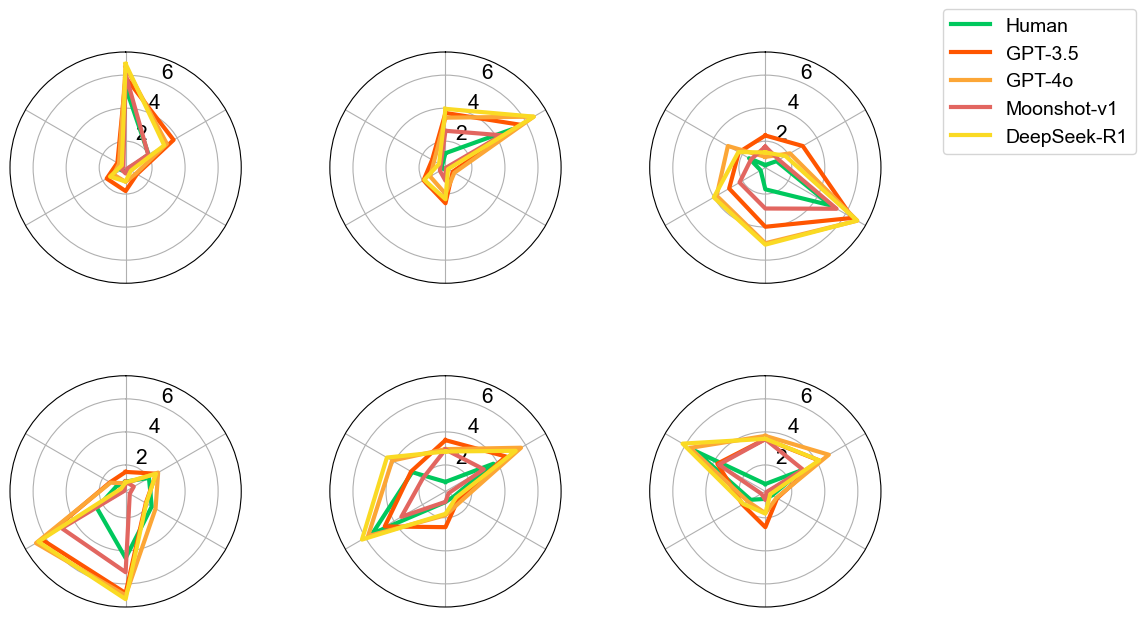

In [38]:

import os
import matplotlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
resultdir = r'Y:\xinke\Danmu\DyEmo-film\Emotion_scores\THU'
with open(os.path.join(resultdir, 'scores_allvideo_deepseek.pkl'), 'rb') as f:
    scores_allvideo = pickle.load(f)
# print(scores_allvideo.keys())
matplotlib.rcParams['font.family'] = 'Arial'
names_new = ['angry_08', 'angry_09', 'angry_10', 'disgust_01', 'disgust_08', 'disgust_10', 'fear_03', 'fear_08', 'fear_09', 'humor_03', 'humor_07', 'humor_08', 'sad_02', 'sad_05', 'sad_06', 'surprise_03', 'surprise_07', 'surprise_10']
ds_data = np.zeros((6,6))
# scores_std = np.zeros((6,6))
count0 = 0
for count in range(0,len(names_new),3):
    scores_tmp = np.zeros((0,6))
    for i in range(3):
        scores_tmp = np.concatenate((scores_tmp, scores_allvideo[names_new[count+i]]),0)
    ds_data[count0] = np.mean(scores_tmp, axis=0)
    # scores_std[count0] = np.std(scores_tmp, axis=0)
    count0 += 1
ds_data = ds_data[[3,5,4,0,1,2]]


with open(os.path.join(resultdir, 'scores_allvideo_kimi.pkl'), 'rb') as f:
    scores_allvideo = pickle.load(f)

matplotlib.rcParams['font.family'] = 'Arial'
names_new = ['angry_08', 'angry_09', 'angry_10', 'disgust_01', 'disgust_08', 'disgust_10', 'fear_03', 'fear_08', 'fear_09', 'humor_03', 'humor_07', 'humor_08', 'sad_02', 'sad_05', 'sad_06', 'surprise_03', 'surprise_07', 'surprise_10']
kimi_data = np.zeros((6,6))
# scores_std = np.zeros((6,6))
count0 = 0
for count in range(0,len(names_new),3):
    scores_tmp = np.zeros((0,6))
    for i in range(3):
        scores_tmp = np.concatenate((scores_tmp, scores_allvideo[names_new[count+i]]),0)
    kimi_data[count0] = np.mean(scores_tmp, axis=0)
    # scores_std[count0] = np.std(scores_tmp, axis=0)
    count0 += 1
kimi_data = kimi_data[[3,5,4,0,1,2]]

with open(os.path.join(resultdir, 'scores_allvideo_gpt35.pkl'), 'rb') as f:
    scores_allvideo = pickle.load(f)
    
gpt_3_5_turbo_data = np.zeros((6,6))
# scores_std = np.zeros((6,6))
count0 = 0
for count in range(0,len(names_new),3):
    scores_tmp = np.zeros((0,6))
    for i in range(3):
        scores_tmp = np.concatenate((scores_tmp, scores_allvideo[names_new[count+i]]),0)
    gpt_3_5_turbo_data[count0] = np.mean(scores_tmp, axis=0)
    # scores_std[count0] = np.std(scores_tmp, axis=0)
    count0 += 1
gpt_3_5_turbo_data = gpt_3_5_turbo_data[[3,5,4,0,1,2]]
    
with open(os.path.join(resultdir, 'scores_allvideo_gpt4o.pkl'), 'rb') as f:
    scores_allvideo = pickle.load(f)
    
gpt_4o_data = np.zeros((6,6))
# scores_std = np.zeros((6,6))
count0 = 0
for count in range(0,len(names_new),3):
    scores_tmp = np.zeros((0,6))
    for i in range(3):
        scores_tmp = np.concatenate((scores_tmp, scores_allvideo[names_new[count+i]]),0)
    gpt_4o_data[count0] = np.mean(scores_tmp, axis=0)
    # scores_std[count0] = np.std(scores_tmp, axis=0)
    count0 += 1
gpt_4o_data = gpt_4o_data[[3,5,4,0,1,2]]
    
labels = np.array(['Happiness', 'Surprise', 'Sadness', 'Anger', 'Disgust', 'Fear'])
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, axs = plt.subplots(2, 3, subplot_kw=dict(polar=True), figsize=(10, 6))
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
fig.patch.set_alpha(0.0)
matplotlib.rcParams['xtick.major.pad']='10'
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 15
for i, ax in enumerate(axs.flatten()):
    ax.set_facecolor('white') 
    # ax.patch.set_alpha(0)  
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1], [])
    ax.set_yticks([1.6,3.6,5.6], [2,4,6])
    
    color_xticks = [colors[i] if labels[j] == emos[i] else 'black' for j in range(len(labels))]
    for xtick, color in zip(ax.get_xticklabels(), color_xticks):
        xtick.set_color(color)
    
    ax.plot(angles, np.append(scores_human_mean[i], scores_human_mean[i][0]), label='Human', color='#00C85D', linewidth=3)
    ax.plot(angles, np.append(gpt_3_5_turbo_data[i], gpt_3_5_turbo_data[i][0]), label='GPT-3.5', color=colors_4llms[0], linewidth=3)
    ax.plot(angles, np.append(gpt_4o_data[i], gpt_4o_data[i][0]), label='GPT-4o', color=colors_4llms[1], linewidth=3)
    ax.plot(angles, np.append(kimi_data[i], kimi_data[i][0]), label='Moonshot-v1', color=colors_4llms[2], linewidth=3)
    ax.plot(angles, np.append(ds_data[i], ds_data[i][0]), label='DeepSeek-R1', color=colors_4llms[3], linewidth=3)

    ax.set_ylim(0, 7)
    # ax.set_title(emos[i], color=colors[i], fontsize=15, fontweight='bold', pad=20)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize=14)

# plt.subplots_adjust(hspace=2.5)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
# plt.savefig('figures/radar_plot_shortvideos.jpg', dpi=300, bbox_inches='tight')
plt.savefig('figures/radar_plot_shortvideos_withlegend.svg', dpi=300, bbox_inches='tight')
plt.show()